# Digital Twin model

## Initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ML.DTPredictor import DTPredictor
from ML.Model import Predicter
from PreProcessing.DataManipulation import DataManipulation
import pickle

In [2]:
MODEL_PREFIX = "deep"
SAVE_MODELS = False

In [3]:
dm = DataManipulation("../data/deep-scenario.csv")
dm.data.head(3)

,Execution,ScenarioID,Configuration_API_Description,Attribute[TTC],Attribute[DTO],Attribute[Jerk],Attribute[COL],Attribute[COLT],Attribute[SAC],reward,road,strategy,scenario
0,0,0_scenario_0,A red BoxTruck is overtaking (near) the ego ve...,100000.000000,24.810964,3.48,False,NaN,0.0,dto,road1,greedy,rain_day
1,0,0_scenario_1,A skyblue SUV is driving from the opposite dir...,100000.000000,8.654072,1.04,False,NaN,0.0,dto,road1,greedy,rain_day
2,0,0_scenario_2,A skyblue BoxTruck is driving ahead (near) of ...,2.103269,10.209357,4.98,False,NaN,0.0,dto,road1,greedy,rain_day


## Data Manipulation

In [4]:
dm.addFromXML("../data/dataFromXML.csv")

In [5]:
ids = [268, 273, 477, 1406, 1662, 1961, 2000, 2001, 2002, 2091]
cols = ["Attribute[DTO]", "speed1", "speed2", "speed3", "speed4", "speed5", "speed6", "Attribute[SAC]"]
# dm.data.loc[dm.data["Attribute[COL]"] == True][["Attribute[DTO]", "speed1", "speed2", "speed3", "speed4", "speed5", "speed6", "Attribute[SAC]"]]
dm.data.iloc[ids][cols]

,Attribute[DTO],speed1,speed2,speed3,speed4,speed5,speed6,Attribute[SAC]
268,4.805712,3.148351,4.298646,4.163691,3.343067,4.1316,5.7168,4.442793
273,4.841434,1.844157,1.778300,2.067993,2.334000,4.7772,6.7092,2.346909
477,4.922002,2.082011,1.097750,2.164800,3.240000,3.6924,5.2764,2.378859
1406,7.605580,3.292620,4.620499,3.957729,4.499646,4.4460,5.1624,3.715036
1662,4.888965,1.954391,2.626015,3.151200,4.480800,6.2064,6.7392,3.522738
1961,4.984081,6.105205,5.217909,6.508054,6.006000,8.1984,8.3784,5.225631
2000,50.289233,0.098400,1.706400,3.004800,0.008400,0.0036,0.0012,1.340647
2001,25.204523,0.162000,1.777200,3.098400,0.003600,0.0024,0.0060,0.217742
2002,27.160148,0.162000,1.868400,3.333600,0.003600,0.0060,0.0048,0.344920
2091,5.021879,4.160741,2.773915,3.925200,5.504400,7.2732,8.9016,3.923682


## Model

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [7]:
dm.underSample(3000)
dm.data.value_counts("Attribute[COL]")

Attribute[COL]
False    3000
True     1050
Name: count, dtype: int64

In [8]:
trainX, trainY, testX, testY = dm.splitTrainTest()
print(f"trainX:{trainX.shape}, trainY:{trainY.shape}, testX:{testX.shape}, testY:{testY.shape}")

splitting at 3240.
trainX:(3240, 30), trainY:(3240, 4), testX:(810, 30), testY:(810, 4)


### MLP Classifier

In [9]:
mlp_clf = Predicter()
mlp_trainX, mlp_trainY = mlp_clf.preProcess(trainX.copy(), trainY.copy())
mlp_testX, mlp_testY = mlp_clf.preProcess(testX.copy(), testY.copy())

mlp_clf.fit(mlp_trainX, mlp_trainY)

Scaler is fitted


d:\Dev\School\Venvs\MasterThesis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [10]:
mlp_pred = mlp_clf.predict(mlp_testX)
mlp_score = mlp_clf.getScore(mlp_pred, mlp_testY)

Total: 810, number of collisions: 217
	TN: 573 	| FP: 20 
	FN: 28 	| TP: 189
Accuracy: 0.94
Precision: 0.9
Recall: 0.87
F1: 0.89


In [13]:
mlp_fpr, mlp_tpr, mlp_thresholds = roc_curve(mlp_testY, mlp_pred)
mlp_roc_auc = auc(mlp_fpr, mlp_tpr)

In [14]:
model_score = f"{mlp_score[0][0]}-{mlp_score[0][1]}-{mlp_score[1][0]}-{mlp_score[1][1]}"
if SAVE_MODELS:
    mlp_clf.saveModel(f"MLPClassifier_{MODEL_PREFIX}", accuracy=model_score)

### Random Forest

In [15]:
rf_clf = DTPredictor(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1))
rf_trainX, rf_trainY = rf_clf.preProcess(trainX.copy(), trainY.copy())
rf_testX, rf_testY = rf_clf.preProcess(testX.copy(), testY.copy())

rf_clf.fit(rf_trainX, rf_trainY)

Scaler is fitted


In [16]:
rf_pred = rf_clf.predict(rf_testX)
rf_score = rf_clf.getScore(rf_testY, rf_pred)

Total: 810, Collisions: 217
Accuracy: 0.9530864197530864, Precision: 0.945273631840796, Recall: 0.8755760368663594, F1: 0.9090909090909091
Confusion matrix:
[[582  11]
 [ 27 190]]


In [17]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(rf_testY, rf_pred)
rf_roc_auc = auc(rf_fpr, rf_tpr)

In [18]:
model_score = f"{rf_score[0][0]}-{rf_score[0][1]}-{rf_score[1][0]}-{rf_score[1][1]}"

if SAVE_MODELS:
    rf_clf.saveModel(f"RandomForestClassifier_{MODEL_PREFIX}", accuracy=model_score)

### Support Vector Machine - Classifier

In [19]:
svm_clf = DTPredictor(SVC(random_state=1))
svm_trainX, svm_trainY = svm_clf.preProcess(trainX.copy(), trainY.copy())
svm_testX, svm_testY = svm_clf.preProcess(testX.copy(), testY.copy())

Scaler is fitted


In [20]:
svm_clf.fit(svm_trainX, svm_trainY)

In [21]:
svm_pred = svm_clf.predict(svm_testX)
svm_score = svm_clf.getScore(svm_testY, svm_pred)

Total: 810, Collisions: 217
Accuracy: 0.9, Precision: 0.930379746835443, Recall: 0.6774193548387096, F1: 0.7839999999999999
Confusion matrix:
[[582  11]
 [ 70 147]]


In [22]:
svm_fpr, svm_tpr, svm_thresholds = roc_curve(svm_testY, svm_pred)
svm_roc_auc = auc(svm_fpr, svm_tpr)

In [23]:
model_score = f"{svm_score[0][0]}-{svm_score[0][1]}-{svm_score[1][0]}-{svm_score[1][1]}"

if SAVE_MODELS:
    svm_clf.saveModel(f"SVC_{MODEL_PREFIX}", accuracy=model_score)

### xgboost - Classifier

In [24]:
xgb_clf = DTPredictor(XGBClassifier(n_estimators=100, random_state=1))
xgb_trainX, xgb_trainY = xgb_clf.preProcess(trainX.copy(), trainY.copy())
xgb_testX, xgb_testY = xgb_clf.preProcess(testX.copy(), testY.copy())

Scaler is fitted


In [25]:
xgb_clf.fit(xgb_trainX, xgb_trainY)

In [26]:
xgb_pred = xgb_clf.predict(xgb_testX)
xgb_score = xgb_clf.getScore(xgb_testY, xgb_pred)

Total: 810, Collisions: 217
Accuracy: 0.9666666666666667, Precision: 0.9523809523809523, Recall: 0.9216589861751152, F1: 0.936768149882904
Confusion matrix:
[[583  10]
 [ 17 200]]


In [27]:
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(xgb_testY, xgb_pred)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

In [28]:
model_score = f"{xgb_score[0][0]}-{xgb_score[0][1]}-{xgb_score[1][0]}-{xgb_score[1][1]}"

if SAVE_MODELS:
    xgb_clf.saveModel(f"XGBClassifier_{MODEL_PREFIX}", accuracy=model_score)

---

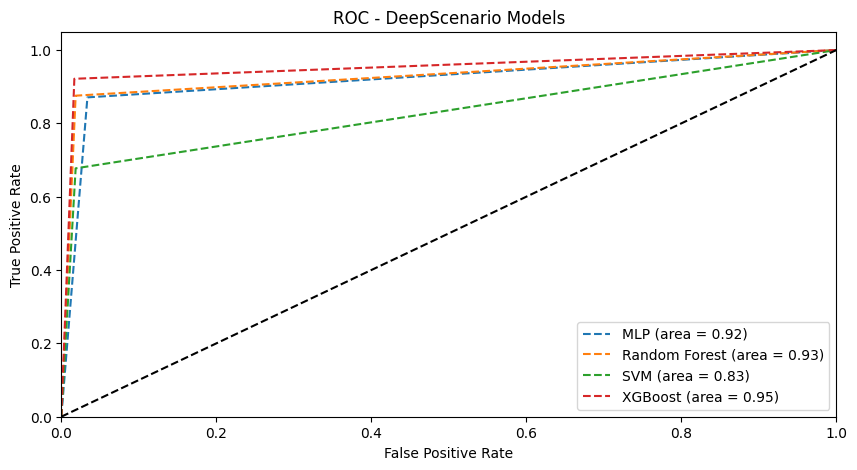

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(mlp_fpr, mlp_tpr, label=f"MLP (area = {mlp_roc_auc:.2f})", linestyle="dashed")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (area = {rf_roc_auc:.2f})", linestyle="dashed")
plt.plot(svm_fpr, svm_tpr, label=f"SVM (area = {svm_roc_auc:.2f})", linestyle="dashed")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (area = {xgb_roc_auc:.2f})", linestyle="dashed")
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC - DeepScenario Models")
plt.legend(loc="lower right")
plt.show()